In [3]:
import tensorflow.compat.v2 as tf
import pandas as pd
import numpy as np
import functools
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from itertools import cycle
import os
import shap
import data_util_val
import shap

In [4]:
def build_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        #logging.info('Global batch size: %d', global_batch_size)
        #logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_finetune = get_preprocess_fn()
        num_classes = 5

        def map_fn(image, label):
            image = preprocess_fn_finetune(image)
            label = tf.one_hot(label, num_classes)
            return image, label

        #logging.info('Using Astro pretrain data')
        dataset = get_data_test()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=False)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = build_input_fn(batch_size)
    return strategy.experimental_distribute_datasets_from_function(input_fn)

def get_preprocess_fn():
    #Get function that accepts an image and returns a preprocessed image
    return functools.partial(
        data_util_val.preprocess_image,
        height = 330,
        width= 330)


def get_data_test():
    #logging.info('Loading Astro test data')
    data_dir = 'imagenes_clasificadas_nair/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('nairTest.csv')
    file_paths = df['name'].values
    labels = df['new_class'].values
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    ds_test = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_test = ds_test.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_test

def get_number_of_images(path_to_csv):
    df = pd.read_csv(path_to_csv)
    return df.shape[0]

In [5]:
strategy = tf.distribute.MirroredStrategy()
ds = build_distributed_dataset(2, strategy)
iterator = iter(ds)
saved_model = tf.saved_model.load('lr1e-3_fineall_balanced_originals/saved_model/27594/')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Instructions for updating:
rename to distribute_datasets_from_function


2021-10-16 00:06:42.945601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 00:06:42.952407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 00:06:42.952898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 00:06:42.971927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 00:06:42.972314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

In [6]:
def f(x):
    return saved_model(x, trainable=False)['logits_sup']

In [7]:
masker_blur = shap.maskers.Image("blur(128,128)", (330, 330, 3))
explainer = shap.Explainer(f, masker_blur, output_names=['0','1','2','3','4'])

In [8]:
imgs = []
lbl = []
for images, labels in iterator:
    imgs.append(images)
    lbl.append(labels)

In [26]:
shap_values = explainer(imgs[3].numpy(), max_evals=12000, batch_size=50, outputs=shap.Explanation.argsort.flip)

  0%|          | 0/5998 [00:00<?, ?it/s]

Partition explainer:  50%|██████████████████████████████████████████████████████████████████                                                                  | 1/2 [00:00<?, ?it/s]

  0%|          | 0/5998 [00:00<?, ?it/s]

Partition explainer: 3it [00:57, 28.97s/it]                                                                                                                                         


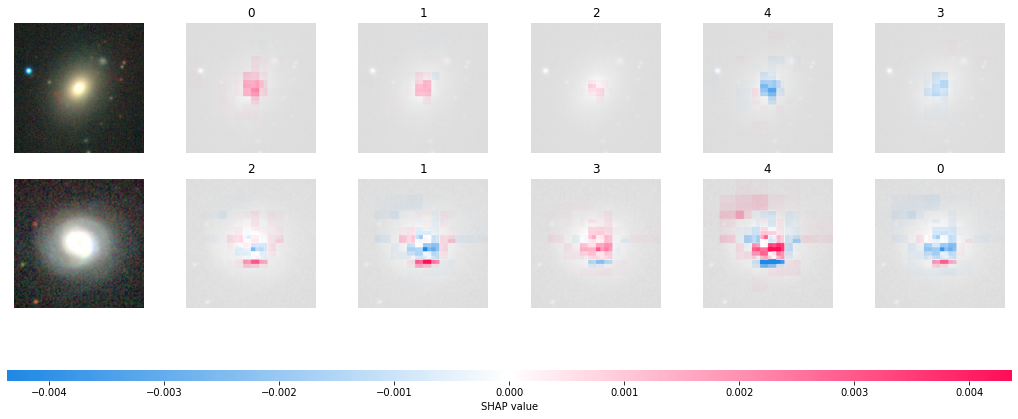

In [27]:
# output with shap values
shap.image_plot(shap_values)

In [29]:
lbl[3]

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

In [12]:
X, y = shap.datasets.imagenet50()

In [ ]:
X[1:3].shape